In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
# matplotlib.rc('pdf', fonttype=42)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [5]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
PROB_DIAB = 0.2
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [6]:
num_runs = 10

In [7]:
min_regrets = [J_star - np.max(joblib.load('./results/run{}/sepsis-cont-1-va.values.joblib'.format(run))['true_value_list']) for run in range(num_runs)]

## Exp 1

In [63]:
num_runs = 10

In [64]:
to_plot = 'Regret'

In [65]:
dfs_tr = [pd.read_csv('./results/run{}/sepsis-cont-1-tr.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va = [pd.read_csv('./results/run{}/sepsis-cont-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_trva = [pd.read_csv('./results/run{}/sepsis-cont-1-trva.csv'.format(run), index_col=0) for run in range(num_runs)]

In [66]:
regrets_tr = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_tr)], axis=1).T.drop(columns=['FQI'])
regrets_tr['Case'] = 'train'
regrets_va = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va)], axis=1).T.drop(columns=['FQI'])
regrets_va['Case'] = 'val'
regrets_trva = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_trva)], axis=1).T.drop(columns=['FQI'])
regrets_trva['Case'] = 'train val'

In [67]:
regrets_exp1 = pd.concat([regrets_tr, regrets_va, regrets_trva])
regrets_exp1.columns.name = 'OPE'
regrets_exp1 = pd.DataFrame(regrets_exp1.set_index('Case').stack().rename(to_plot)).reset_index()

In [68]:
regrets_exp1 = regrets_exp1[regrets_exp1['OPE'].isin(['WIS', 'AM', 'FQE'])]

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


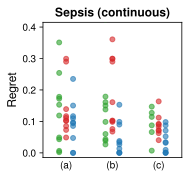

In [69]:
df = regrets_exp1.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['train', 'val', 'train val']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=0, elinewidth=1.25, ls='-', alpha=0.8)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)
    
    yvals = regrets_exp1[regrets_exp1['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.0, 0.6)

ax.tick_params(axis='x', length=0)
plt.xlim(-0.5, 2.5)
plt.xticks([0,1,2], ['(a)', '(b)', '(c)']) #'train $D_1$, val $D_1$', 'train $D_1$, val $D_2$', 'train $D_1+D_2$, val $D_1+D_2$'
plt.ylim(-0.015, 0.415)
# plt.xlabel(' ', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (continuous)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp1-tr_va.pdf', bbox_inches='tight')
plt.show()

## Exp 1a

In [70]:
num_runs = 10

In [71]:
to_plot = 'Suboptimality'

In [72]:
dfs_tr = [pd.read_csv('./results/run{}/sepsis-cont-1-tr.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va = [pd.read_csv('./results/run{}/sepsis-cont-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_trva = [pd.read_csv('./results/run{}/sepsis-cont-1-trva.csv'.format(run), index_col=0) for run in range(num_runs)]

In [73]:
regrets_tr = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_tr)], axis=1).T.drop(columns=['FQI'])
regrets_tr['Case'] = 'train'
regrets_va = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va)], axis=1).T.drop(columns=['FQI'])
regrets_va['Case'] = 'val'
regrets_trva = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_trva)], axis=1).T.drop(columns=['FQI'])
regrets_trva['Case'] = 'train val'

In [74]:
# regrets_va.loc[1, 'WIS'] += 9e-4 # A hack to make points more discernable

In [75]:
regrets_exp1a = pd.concat([regrets_tr, regrets_va, regrets_trva])
regrets_exp1a.columns.name = 'OPE'
regrets_exp1a = pd.DataFrame(regrets_exp1a.set_index('Case').stack().rename(to_plot)).reset_index()

In [76]:
regrets_exp1a = regrets_exp1a[regrets_exp1a['OPE'].isin(['WIS', 'AM', 'FQE'])]

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


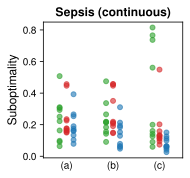

In [77]:
df = regrets_exp1a.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['train', 'val', 'train val']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=0, elinewidth=1.25, ls='-', alpha=0.8)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)
    
    yvals = regrets_exp1a[regrets_exp1a['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)


# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.2, 0.5)

ax.tick_params(axis='x', length=0)
plt.xlim(-0.5, 2.5)
plt.xticks([0,1,2], ['(a)', '(b)', '(c)']) #'train $D_1$, val $D_1$', 'train $D_1$, val $D_2$', 'train $D_1+D_2$, val $D_1+D_2$', rotation=8
plt.ylim(-0.01,0.85)
# plt.yticks(np.arange(0, 0.25, 0.1))
# plt.xlabel(' ', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (continuous)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp1a.pdf', bbox_inches='tight')
plt.show()

## Exp 2

In [12]:
num_runs = 10

In [13]:
to_plot = 'Regret'

In [57]:
dfs_va10k = [pd.read_csv('./results/run{}/sepsis-cont-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va5k = [pd.read_csv('./results/run{}/sepsis-cont-2-va5k.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va1k = [pd.read_csv('./results/run{}/sepsis-cont-2-va1k.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va500 = [pd.read_csv('./results/run{}/sepsis-cont-2-va500.csv'.format(run), index_col=0) for run in range(num_runs)]

In [58]:
regrets_va10k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k)], axis=1).T.drop(columns=['FQI'])
regrets_va10k['Case'] = '10k'
regrets_va5k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va5k)], axis=1).T.drop(columns=['FQI'])
regrets_va5k['Case'] = '5k'
regrets_va1k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va1k)], axis=1).T.drop(columns=['FQI'])
regrets_va1k['Case'] = '1k'
regrets_va500 = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va500)], axis=1).T.drop(columns=['FQI'])
regrets_va500['Case'] = '500'

In [59]:
regrets_exp2 = pd.concat([regrets_va500, regrets_va1k, regrets_va5k, regrets_va10k])
regrets_exp2.columns.name = 'OPE'
regrets_exp2 = pd.DataFrame(regrets_exp2.set_index('Case').stack().rename(to_plot)).reset_index()

In [60]:
regrets_exp2 = regrets_exp2[regrets_exp2['OPE'].isin(['WIS', 'AM', 'FQE'])]

In [61]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


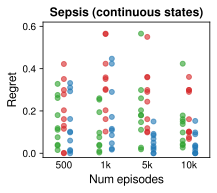

In [62]:
df = regrets_exp2.groupby(['Case', 'OPE']).agg(['min', 'median', 'max', q1, q3]).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['500', '1k', '5k', '10k']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(3, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
    
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=0, elinewidth=0.5, ls='-', alpha=0.8)
    
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=0, elinewidth=0.5, ls='-', alpha=0.8)
#     yq1, yq3 = df.loc[:,('q1', name)], df.loc[:,('q3', name)]
#     yiqrs = np.array([yval-yq1, yq3-yval])
#     plt.errorbar(xpos, yval, yerr=yiqrs, c=color, lw=0, elinewidth=2.0, ls='-', alpha=0.8)
    
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, ls='-', alpha=0.8)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)

    yvals = regrets_exp2[regrets_exp2['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

plt.xlim(-0.5, 3.5)
# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
plt.ylim(-0.02, 0.62)

ax.tick_params(axis='x', length=0)
plt.xticks([0,1,2,3], ['500', '1k', '5k', '10k'])
plt.xlabel('Num episodes', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (continuous states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp2-size.pdf', bbox_inches='tight')
plt.show()

## Exp 3

In [15]:
num_runs = 10

In [16]:
to_plot = 'Regret'

In [17]:
dfs_va10k = [pd.read_csv('./results/run{}/sepsis-cont-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va10k_eps01 = [pd.read_csv('./results/run{}/sepsis-cont-3-va10k_eps01.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va10k_mixed = [pd.read_csv('./results/run{}/sepsis-cont-3-va10k_mixed.csv'.format(run), index_col=0) for run in range(num_runs)]

In [18]:
regrets_va10k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k)], axis=1).T.drop(columns=['FQI'])
regrets_va10k['Case'] = 'Random'
regrets_va10k_eps01 = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k_eps01)], axis=1).T.drop(columns=['FQI'])
regrets_va10k_eps01['Case'] = 'ε-greedy'
regrets_va10k_mixed = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k_mixed)], axis=1).T.drop(columns=['FQI'])
regrets_va10k_mixed['Case'] = 'Mixed'

In [19]:
regrets_exp3 = pd.concat([regrets_va10k, regrets_va10k_mixed, regrets_va10k_eps01])
regrets_exp3.columns.name = 'OPE'
regrets_exp3 = pd.DataFrame(regrets_exp3.set_index('Case').stack().rename(to_plot)).reset_index()

In [20]:
regrets_exp3 = regrets_exp3[regrets_exp3['OPE'].isin(['WIS', 'AM', 'FQE'])]

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


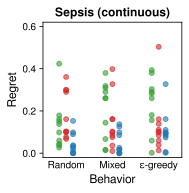

In [36]:
df = regrets_exp3.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['Random', 'Mixed', 'ε-greedy']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, ls='-', alpha=0.8)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)

    yvals = regrets_exp3[regrets_exp3['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

plt.xlim(-0.5, 2.5)
# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.0, 0.9)
plt.ylim(-0.02, 0.62)

ax.tick_params(axis='x', length=0)
plt.xticks([0,1,2], ['Random', 'Mixed', 'ε-greedy'])
plt.xlabel('Behavior', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (continuous)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp3-behavior.pdf', bbox_inches='tight')
plt.show()

## Exp 4

In [22]:
num_runs = 10

In [23]:
to_plot = 'Regret'

In [24]:
L_list = [1, 5, 10, 20, 50]
df_FQE_L = [pd.read_csv('./results/run{}/sepsis-cont-4-FQE_L.csv'.format(run), index_col=0) for run in range(num_runs)]
regrets_FQE_L = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(df_FQE_L)], axis=1).T
regrets_FQE_L.columns = L_list
regrets_FQE_L.columns.name = 'FQE (H)'

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


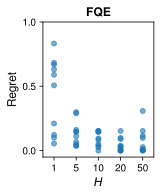

In [47]:
df = regrets_FQE_L.agg(['min', 'median', 'max'])
color = 'tab:blue'
mark = '^'
_, ncases = df.shape

fig, ax = plt.subplots(figsize=(2,2.5))
yval, ylo, yhi = df.loc['median'], df.loc['min'], df.loc['max']
yerrs = np.array([yval-ylo, yhi-yval])
xpos = np.arange(ncases)
# plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, capsize=3, ls='-', alpha=0.8)
# plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=5, zorder=10)

yvals = regrets_FQE_L.values.T.reshape((ncases, num_runs))
plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
plt.ylim(-0.05, 1.0)
plt.yticks([0, 0.5, 1])

# ax.tick_params(axis='x', length=0)
plt.xticks(range(len(L_list)), L_list)
plt.xlim(-0.5, 4.5)
plt.xlabel('$H$', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('FQE', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp4-FQE_L.pdf', bbox_inches='tight')
plt.show()

In [28]:
L_list = [1, 5, 10, 20, 50]
df_AM_L = [pd.read_csv('./results/run{}/sepsis-cont-4-AM_L.csv'.format(run), index_col=0) for run in range(num_runs)]
regrets_AM_L = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(df_AM_L)], axis=1).T
regrets_AM_L.columns = L_list
regrets_AM_L.columns.name = 'AM (H)'

In [29]:
regrets_AM_L

AM (H),1,5,10,20,50
0,0.067604,0.067604,0.067604,0.067604,0.067604
1,0.289959,0.289959,0.289959,0.289959,0.289959
2,0.101984,0.101984,0.101984,0.101984,0.101984
3,0.299205,0.299205,0.299205,0.299205,0.299205
4,0.360893,0.360893,0.360893,0.360893,0.360893
5,0.161102,0.161102,0.161102,0.161102,0.161102
6,0.299371,0.299371,0.299371,0.299371,0.299371
7,0.102631,0.102631,0.102631,0.102631,0.102631
8,0.098523,0.098523,0.098523,0.098523,0.098523
9,0.075806,0.075806,0.075806,0.075806,0.075806


'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


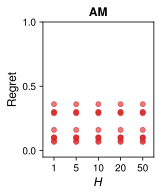

In [48]:
df = regrets_AM_L.agg(['min', 'median', 'max'])
color = 'tab:red'
mark = 'd'
_, ncases = df.shape

fig, ax = plt.subplots(figsize=(2,2.5))
yval, ylo, yhi = df.loc['median'], df.loc['min'], df.loc['max']
yerrs = np.array([yval-ylo, yhi-yval])
xpos = np.arange(ncases)
# plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, capsize=3, ls='-', alpha=0.8)
# plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=5, zorder=10)

yvals = regrets_AM_L.values.T.reshape((ncases, num_runs))
plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)
# plt.ylim(0.0, 0.4)

# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
plt.ylim(-0.05, 1.0)
plt.yticks([0, 0.5, 1])

# ax.tick_params(axis='x', length=0)
plt.xticks(range(len(L_list)), L_list)
plt.xlim(-0.5, 4.5)
plt.xlabel('$H$', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('AM', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp4-AM_L.pdf', bbox_inches='tight')
plt.show()

In [31]:
eps_list = [0, 0.01, 0.05, 0.10, 0.50, 1]
df_WIS_eps = [pd.read_csv('./results/run{}/sepsis-cont-4-WIS_eps.csv'.format(run), index_col=0) for run in range(num_runs)]
regrets_WIS_eps = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(df_WIS_eps)], axis=1).T
regrets_WIS_eps.columns = eps_list
regrets_WIS_eps.columns.name = 'WIS (eps)'

In [43]:
regrets_WIS_eps

WIS (eps),0.00,0.01,0.05,0.10,0.50,1.00
0,0.137995,0.137995,0.137995,0.000000,0.179964,1.283923
1,0.026781,0.026781,0.026781,0.026781,0.093145,0.638531
2,0.043279,0.043279,0.550034,0.550034,0.727722,1.570460
3,0.178878,0.178878,0.312524,0.312524,0.312524,1.439928
4,0.059899,0.059899,0.675606,0.675606,0.668770,1.381528
5,0.116668,0.161102,0.161102,0.161102,0.161102,1.311558
6,0.423418,0.423418,0.200263,0.200263,0.632073,1.440198
7,0.038669,0.038669,0.038669,0.038669,0.118734,1.075667
8,0.098523,0.098523,0.098523,0.098523,0.275705,1.257275
9,0.184140,0.150343,0.087334,0.087334,0.083092,1.363595


'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


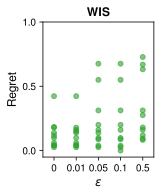

In [49]:
df = regrets_WIS_eps.agg(['min', 'median', 'max'])
color = 'tab:green'
mark = 'o'
_, ncases = df.shape

fig, ax = plt.subplots(figsize=(2,2.5))
yval, ylo, yhi = df.loc['median'], df.loc['min'], df.loc['max']
yerrs = np.array([yval-ylo, yhi-yval])
xpos = np.arange(ncases)
# plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, capsize=3, ls='-', alpha=0.8)
# plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=5, zorder=10)

yvals = regrets_WIS_eps.values.T.reshape((ncases, num_runs))
plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)
# plt.ylim(0.0, 0.4)

# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
plt.ylim(-0.05, 1.0)
plt.yticks([0, 0.5, 1])

# ax.tick_params(axis='x', length=0)
# plt.xscale('symlog', linthresh=0.01)
# plt.xticks(eps_list, eps_list)
# plt.xlim(-0.001, 1.15)
plt.xticks(range(len(eps_list)), eps_list)
plt.xlim(-0.5, 4.5)
plt.xlabel('$\epsilon$', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('WIS', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp4-WIS_eps.pdf', bbox_inches='tight')
plt.show()